# Analyzing NYC's Stormwater Flood Map - Extreme Flood Scenario
## Objective: Data Wrangling

Mark Bauer

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as ctx

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,seaborn,matplotlib,geopandas

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy     : 1.22.4
pandas    : 1.4.2
seaborn   : 0.11.2
matplotlib: 3.5.2
geopandas : 0.9.0



In [3]:
# check data
%ls data/

stormwater-data-source/ stormwater-data.zip


In [4]:
gdf = gpd.read_file('data/stormwater-data.zip')

# sanity checks
print('shape: {}'.format(gdf.shape))
print('crs: {}'.format(gdf.crs))

gdf.head()

shape: (12036, 5)
crs: epsg:2263


,Flooding_Category,flood_classification,Shape_Length,Shape_Area,geometry
0,1,Nuisance Flooding,1695.857677,27852.535494,"POLYGON Z ((916393.149 121765.469 0.000, 91640..."
1,1,Nuisance Flooding,1532.269198,18338.901687,"POLYGON Z ((917251.502 121381.664 0.000, 91725..."
2,1,Nuisance Flooding,2327.963831,32127.388341,"POLYGON Z ((916251.188 121441.271 0.000, 91625..."
3,1,Nuisance Flooding,3830.095703,48711.665246,"POLYGON Z ((917377.109 122108.195 0.000, 91739..."
4,1,Nuisance Flooding,4600.270710,65321.650657,"POLYGON Z ((918159.499 121451.773 0.000, 91814..."


In [5]:
# summary statistics
(gdf
 .groupby(by='flood_classification')[['flood_classification']]
 .count()
 .rename(columns={'flood_classification':'count_polygons'})
)

,count_polygons
flood_classification,
Deep and Contiguous Flooding,3703
Future High Tides 2080,407
Nuisance Flooding,7926


In [6]:
# summary statistics
acres_conversion = 43560

(gdf
 .groupby(by='flood_classification')[['Shape_Area']]
 .sum()
 .div(acres_conversion)
 .round(0)
 .astype(int)
 .rename(columns={'Shape_Area':'shape_area_acres'})
)

,shape_area_acres
flood_classification,
Deep and Contiguous Flooding,6093
Future High Tides 2080,7883
Nuisance Flooding,6887


# Boroughs

In [7]:
# importing borough boundaries
path = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile'
borough_gdf = gpd.read_file(path)

print('shape of data: {}'.format(borough_gdf.shape))
borough_gdf.head()

shape of data: (5, 5)


,boro_code,boro_name,shape_area,shape_leng,geometry
0,5.0,Staten Island,1.623621e+09,325917.353950,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,2.0,Bronx,1.187175e+09,463179.772813,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
2,4.0,Queens,3.041419e+09,888199.730955,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."
3,1.0,Manhattan,6.365205e+08,357713.308660,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
4,3.0,Brooklyn,1.934138e+09,728148.532410,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."


In [8]:
# examine crs
borough_gdf.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [9]:
# transform crs
borough_gdf = borough_gdf.to_crs(2263)

borough_gdf.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Text(0.5, 1.0, 'NYC Boroughs')

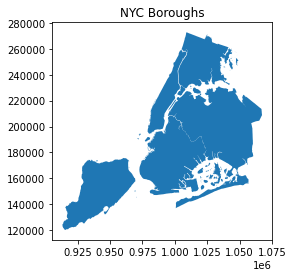

In [10]:
# quick sanity plot of boroughs
borough_gdf.plot()
plt.title('NYC Boroughs')

# Exploratory Maps of Flood Classifications

In [11]:
gdf.head()

,Flooding_Category,flood_classification,Shape_Length,Shape_Area,geometry
0,1,Nuisance Flooding,1695.857677,27852.535494,"POLYGON Z ((916393.149 121765.469 0.000, 91640..."
1,1,Nuisance Flooding,1532.269198,18338.901687,"POLYGON Z ((917251.502 121381.664 0.000, 91725..."
2,1,Nuisance Flooding,2327.963831,32127.388341,"POLYGON Z ((916251.188 121441.271 0.000, 91625..."
3,1,Nuisance Flooding,3830.095703,48711.665246,"POLYGON Z ((917377.109 122108.195 0.000, 91739..."
4,1,Nuisance Flooding,4600.270710,65321.650657,"POLYGON Z ((918159.499 121451.773 0.000, 91814..."


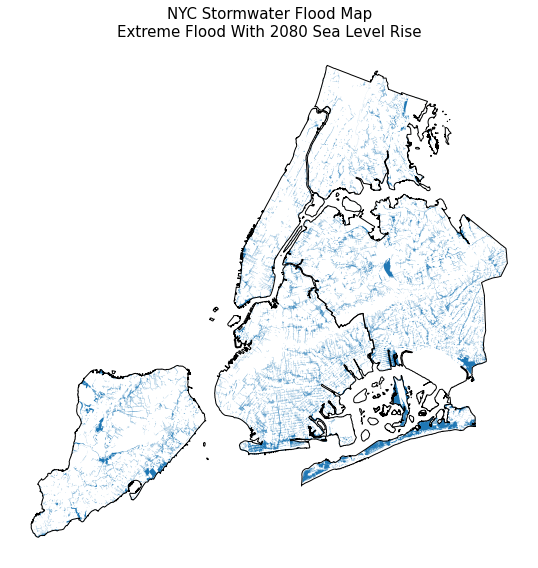

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))

gdf.plot(ax=ax)

borough_gdf.plot(
    ax=ax,
    facecolor='none', 
    edgecolor='black', 
    zorder=1
)

plt.title('NYC Stormwater Flood Map\nExtreme Flood With 2080 Sea Level Rise', fontsize=15)
plt.axis('off')
plt.tight_layout()

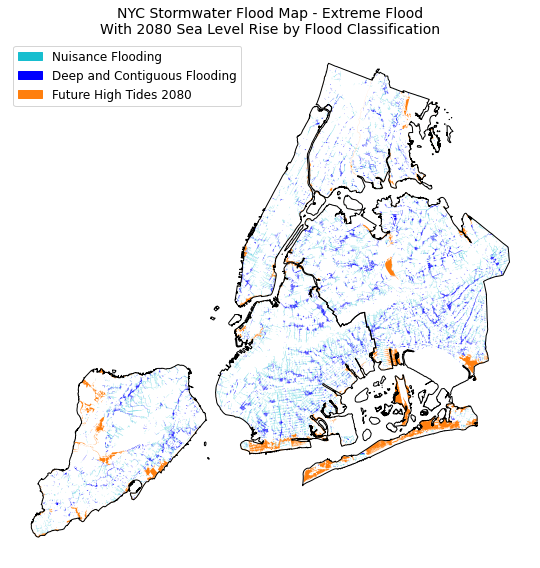

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))

patches = []
colors = ['tab:cyan', 'blue', 'tab:orange']
classifications = gdf['flood_classification'].unique()

for label, color in zip(classifications, colors):
    (gdf
     .loc[gdf['flood_classification'].isin([label])]
     .plot(color=color, ax=ax)
)
    
    patches.append(mpatches.Patch(color=color, label=label))
    
borough_gdf.plot(
    ax=ax, 
    facecolor='none', 
    edgecolor='black', 
    zorder=1
)

plt.legend(
    title='', 
    handles=patches, 
    fontsize='12', 
    loc=2
) 

title = 'NYC Stormwater Flood Map - Extreme Flood\nWith 2080 Sea Level Rise by Flood Classification'
plt.title(title, fontsize=14)
plt.axis('off')
plt.tight_layout()

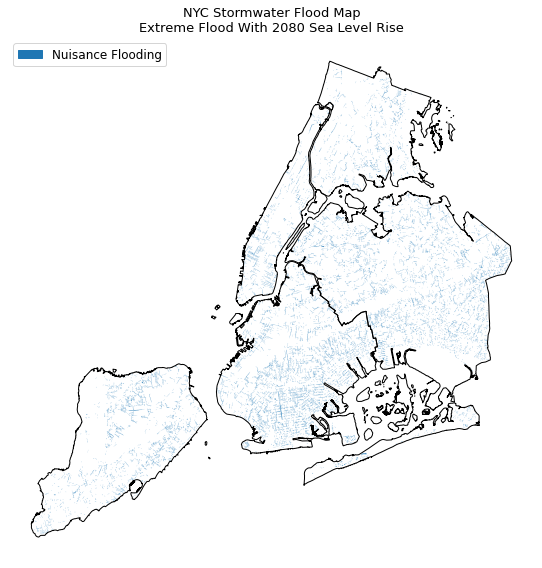

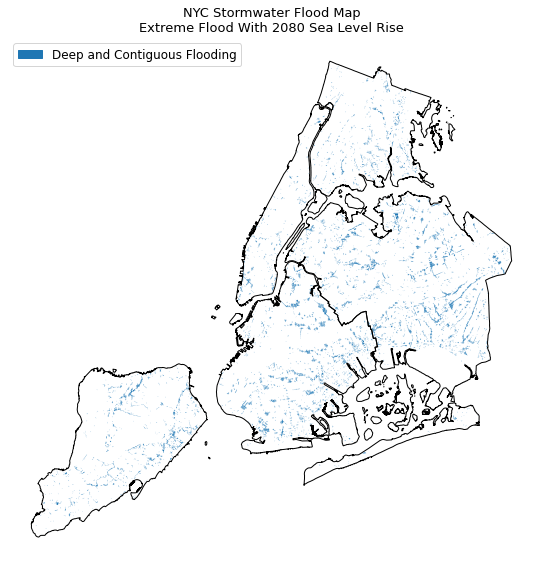

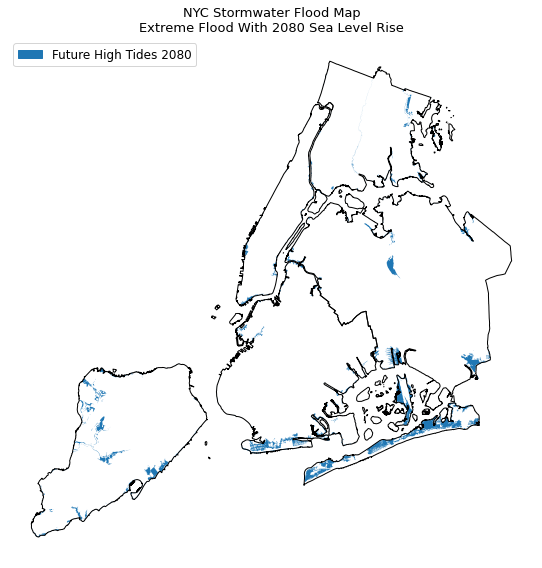

In [14]:
classifications = gdf['flood_classification'].unique()
color = 'C0'

for label in classifications:
    fig, ax = plt.subplots(figsize=(8, 8))
    
    (gdf
     .loc[gdf['flood_classification'].isin([label])]
     .plot(color=color, ax=ax, legend=True)
    )
    
    patches = [mpatches.Patch(color=color, label=label)]
    
    borough_gdf.plot(
        ax=ax,
        facecolor='none',
        edgecolor='black',
        zorder=1
    )
    
    plt.legend(
        title='', 
        handles=patches, 
        fontsize='12', 
        loc=2
    ) 
    
    title = 'NYC Stormwater Flood Map\nExtreme Flood With 2080 Sea Level Rise'
    plt.title(title, fontsize=13)
    plt.axis('off')
    plt.tight_layout()

## Clip Flood Polygons by Borough

In [15]:
%%time
boros = borough_gdf['boro_name'].unique()
lst = []

for boro in boros:
    
    mask = borough_gdf.loc[borough_gdf['boro_name'] == boro]
    gdf['geometry'] = gdf['geometry'].buffer(0)
    
    clipped = gpd.clip(gdf, mask)
    clipped['boro'] = boro
    lst.append(clipped)

clipped_gdf = pd.concat(lst).reset_index(drop=True)

clipped_gdf['Shape_Area'] = clipped_gdf.area
clipped_gdf['Shape_Length'] = clipped_gdf.length

print('shape of data: {}'.format(clipped_gdf.shape))
clipped_gdf.head()

shape of data: (12076, 6)
CPU times: user 1min 27s, sys: 740 ms, total: 1min 28s
Wall time: 1min 29s


,Flooding_Category,flood_classification,Shape_Length,Shape_Area,geometry,boro
0,1,Nuisance Flooding,1695.857677,27852.535494,"POLYGON Z ((916405.124 121753.026 0.000, 91641...",Staten Island
1,1,Nuisance Flooding,1532.269198,18338.901687,"POLYGON Z ((917251.502 121394.523 0.000, 91723...",Staten Island
2,1,Nuisance Flooding,2327.963831,32127.388341,"POLYGON Z ((916254.418 121431.775 0.000, 91625...",Staten Island
3,1,Nuisance Flooding,3830.095703,48711.665246,"POLYGON Z ((917395.081 122108.181 0.000, 91741...",Staten Island
4,1,Nuisance Flooding,4600.270710,65321.650657,"POLYGON Z ((917905.522 121601.079 0.000, 91791...",Staten Island


## Clipped Deep and Continuous Flooding

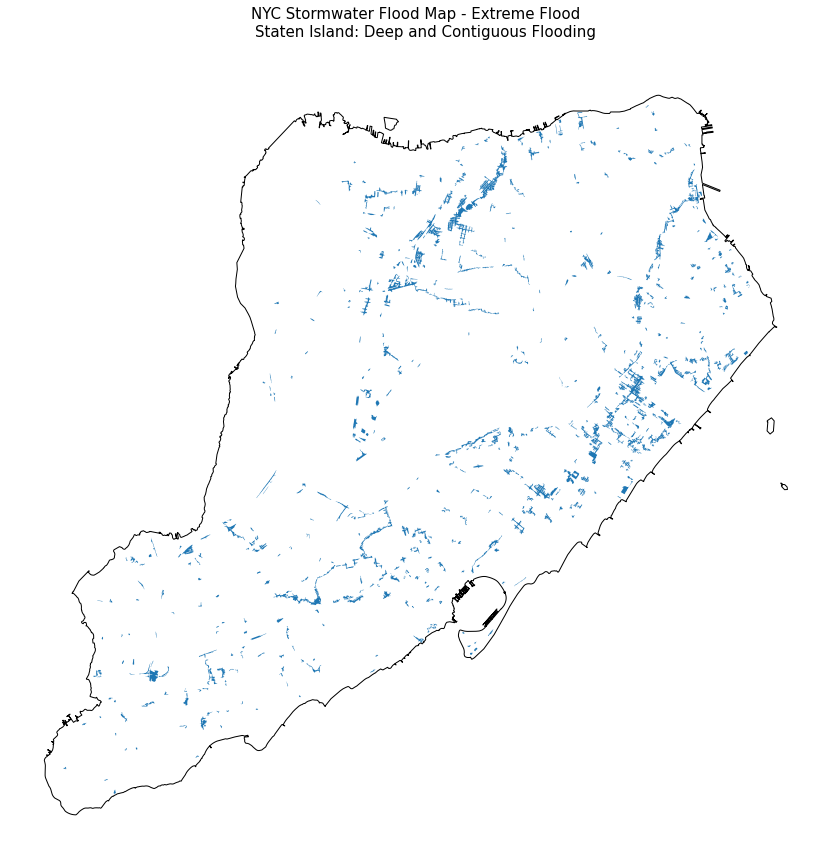

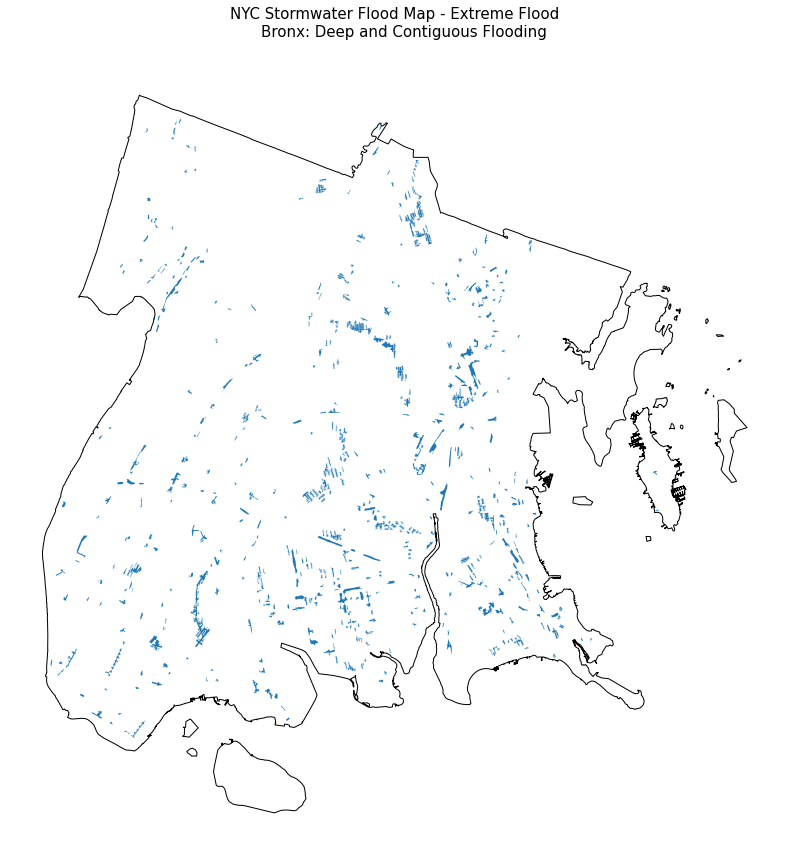

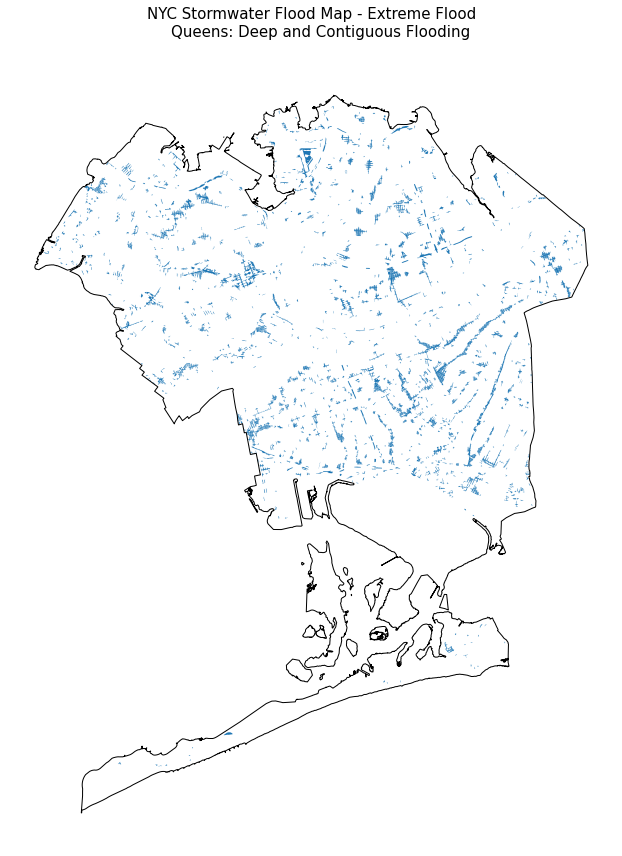

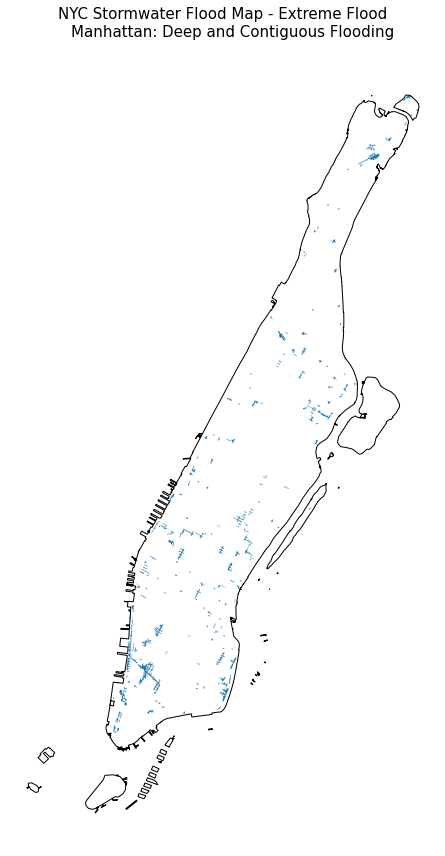

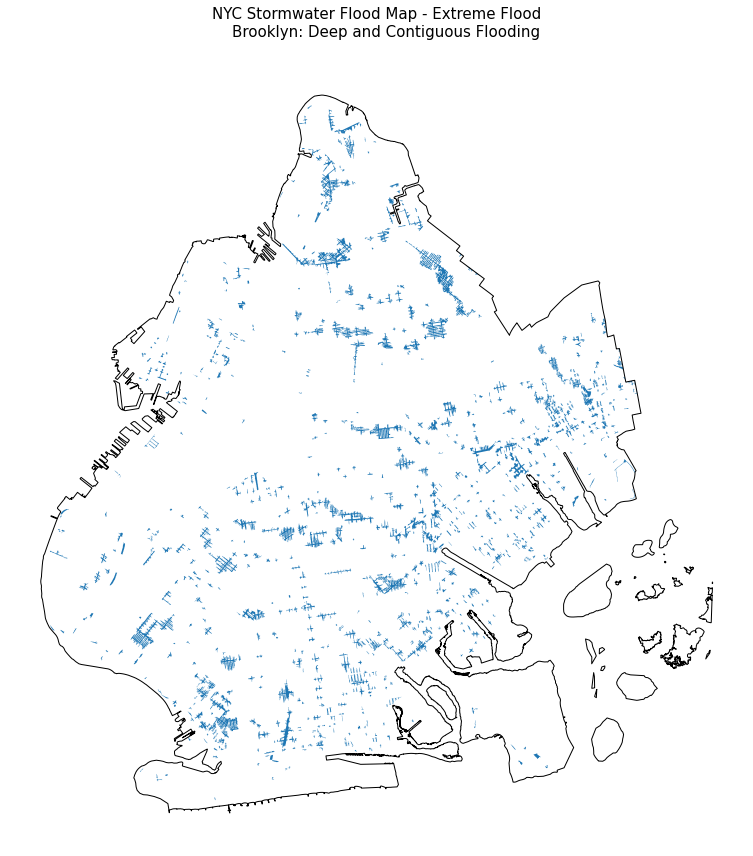

In [16]:
boros = borough_gdf['boro_name'].to_list()
deep_df = clipped_gdf.loc[clipped_gdf['flood_classification'] == 'Deep and Contiguous Flooding']

for boro in boros: 
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    (deep_df
     .loc[deep_df['boro'].isin([boro])]
     .plot(ax=ax)
    )

    (borough_gdf
     .loc[borough_gdf['boro_name'] == boro]
     .plot(ax=ax, facecolor='none', edgecolor='black', zorder=1)
    )

    plt.axis('off')
    plt.title('NYC Stormwater Flood Map - Extreme Flood\n\
    {}: Deep and Contiguous Flooding\n'.format(boro), fontsize=15)   
    plt.tight_layout()

## Future High Tides 2080

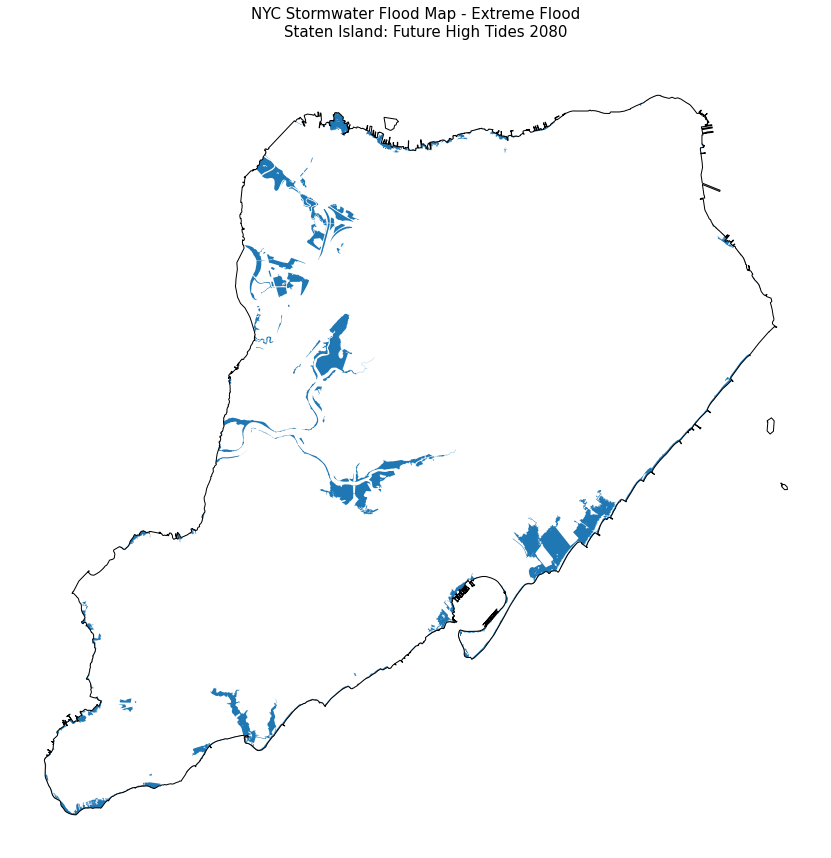

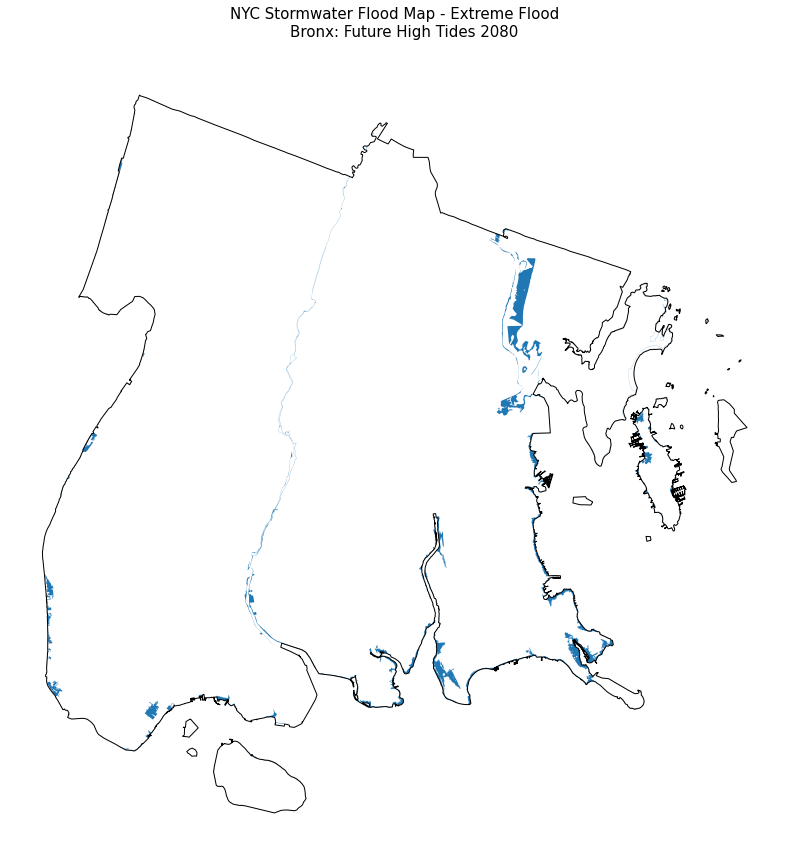

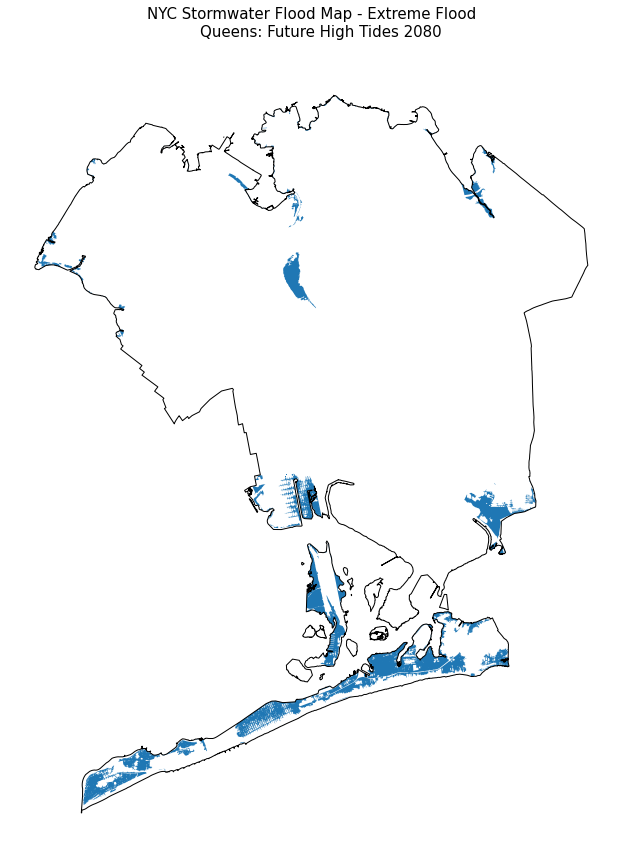

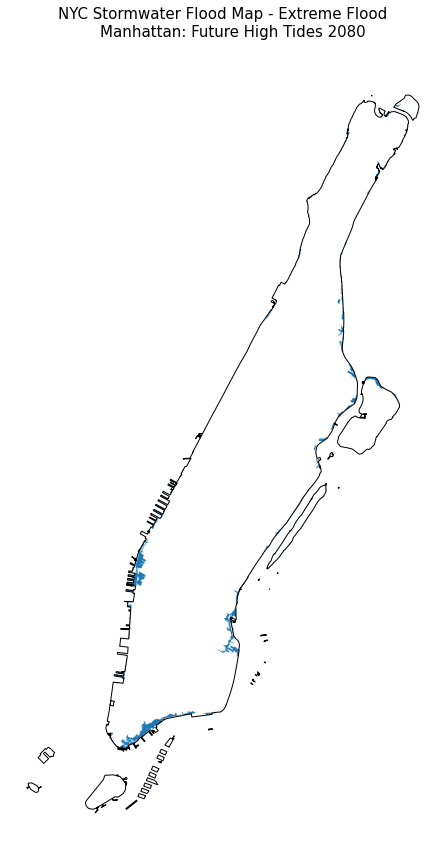

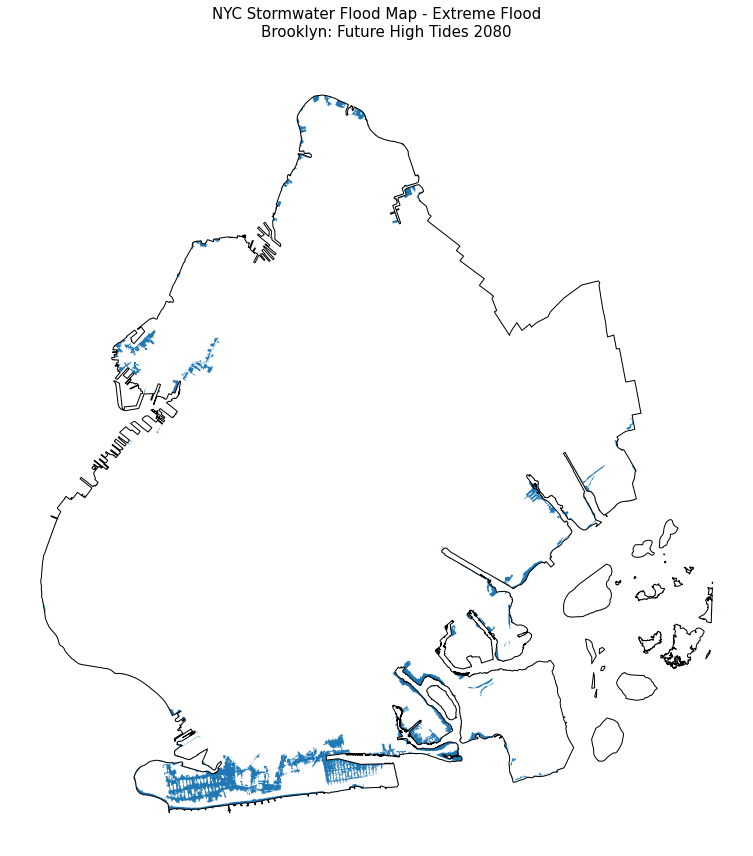

In [17]:
boros = borough_gdf['boro_name'].to_list()
high_tides_df = clipped_gdf.loc[clipped_gdf['flood_classification'] == 'Future High Tides 2080']

for boro in boros: 
    fig, ax = plt.subplots(figsize=(12, 12))
    
    (high_tides_df
     .loc[high_tides_df['boro'].isin([boro])]
     .plot(ax=ax)
    )

    (borough_gdf
     .loc[borough_gdf['boro_name'] == boro]
     .plot(ax=ax, facecolor='none', edgecolor='black', zorder=1)
    )

    plt.axis('off')
    plt.title('NYC Stormwater Flood Map - Extreme Flood\n\
    {}: Future High Tides 2080\n'.format(boro), fontsize=15)   
    plt.tight_layout()

# Neighborhood Tabulation Areas

In [18]:
# importing neighborhood boundaries
path = 'https://data.cityofnewyork.us/api/geospatial/9nt8-h7nd?accessType=DOWNLOAD&method=export&format=Shapefile'
nta_gdf = gpd.read_file(path)

print('shape of data: {}'.format(nta_gdf.shape))
nta_gdf.head()

shape of data: (262, 12)


,borocode,boroname,countyfips,nta2020,ntaname,ntaabbrev,ntatype,cdta2020,cdtaname,shape_leng,shape_area,geometry
0,1.0,Manhattan,061,MN6491,Central Park,CntrlPk,9,MN64,MN64 Central Park (JIA 64 Equivalent),32721.097429,3.831238e+07,"POLYGON ((-73.95246 40.79824, -73.95237 40.798..."
1,1.0,Manhattan,061,MN0401,Chelsea-Hudson Yards,Chls_HdsYd,0,MN04,MN04 Chelsea-Hell's Kitchen (CD 4 Approximation),40095.235570,2.967175e+07,"POLYGON ((-74.00440 40.76267, -74.00220 40.761..."
2,1.0,Manhattan,061,MN0301,Chinatown-Two Bridges,Chntwn,0,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),16464.371337,1.154263e+07,"POLYGON ((-73.98915 40.71671, -73.98975 40.715..."
3,1.0,Manhattan,061,MN1102,East Harlem (North),EstHrlm_N,0,MN11,MN11 East Harlem (CD 11 Equivalent),28710.999462,2.610451e+07,"MULTIPOLYGON (((-73.92719 40.79735, -73.92735 ..."
4,1.0,Manhattan,061,MN1101,East Harlem (South),EstHrlm_S,0,MN11,MN11 East Harlem (CD 11 Equivalent),18682.264948,1.665394e+07,"POLYGON ((-73.94103 40.79255, -73.93865 40.791..."


In [19]:
# examine crs
nta_gdf.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [20]:
# transform crs
nta_gdf = nta_gdf.to_crs(2263)

nta_gdf.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [21]:
# examine if/any multipolygons
nta_gdf['geometry'].geom_type.value_counts()

Polygon         228
MultiPolygon     34
dtype: int64

(905464.7390380852, 1075092.8783935553, 112492.5738036502, 280480.09001459717)

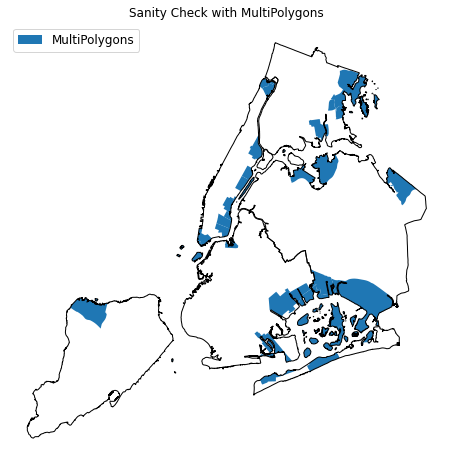

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))

(nta_gdf
 .loc[nta_gdf['geometry'].geom_type.isin(['MultiPolygon'])]
 .plot(ax=ax)
)

borough_gdf.plot(ax=ax, color='None')

patches = [mpatches.Patch(label='MultiPolygons')]
plt.legend(handles=patches, loc=2, fontsize=12)

plt.title('Sanity Check with MultiPolygons')
plt.axis('off')

Text(0.5, 1.0, 'NYC Neighborhood Tabulation Areas')

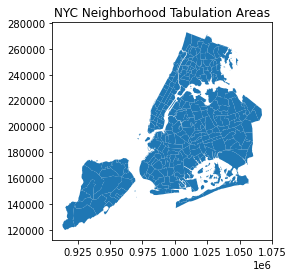

In [23]:
# quick sanity plot of boroughs
nta_gdf.plot()
plt.title('NYC Neighborhood Tabulation Areas')

## Clip Flood Polygons by Neighborhood Tabulation Areas

In [24]:
%%time
ntas = nta_gdf['ntaname'].unique()
lst = []

for nta in ntas:
    
    mask = nta_gdf.loc[nta_gdf['ntaname'] == nta]
    gdf['geometry'] = gdf['geometry'].buffer(0)
    
    clipped = gpd.clip(gdf, mask)
    clipped['ntaname'] = nta
    lst.append(clipped)

clipped_gdf = pd.concat(lst).reset_index(drop=True)

clipped_gdf['Shape_Area'] = clipped_gdf.area
clipped_gdf['Shape_Length'] = clipped_gdf.length

print('shape of data: {}'.format(clipped_gdf.shape))
clipped_gdf.head()

shape of data: (14139, 6)
CPU times: user 53min 51s, sys: 24 s, total: 54min 15s
Wall time: 54min 37s


,Flooding_Category,flood_classification,Shape_Length,Shape_Area,geometry,ntaname
0,1,Nuisance Flooding,997.896831,11764.764800,"POLYGON Z ((989502.923 219532.194 0.000, 98951...",Central Park
1,1,Nuisance Flooding,909.683868,10867.391519,"MULTIPOLYGON Z (((994245.122 222327.931 0.000,...",Central Park
2,1,Nuisance Flooding,1419.027108,14476.612669,"MULTIPOLYGON Z (((996378.141 226133.589 0.000,...",Central Park
3,1,Nuisance Flooding,132.105603,579.257681,"POLYGON Z ((998039.417 229133.663 0.000, 99802...",Central Park
4,1,Nuisance Flooding,141.228932,1101.267642,"POLYGON Z ((998182.392 229673.957 0.000, 99817...",Central Park


In [25]:
nta_area = (
    clipped_gdf
    .groupby(by=['ntaname', 'flood_classification'])[['Shape_Area']]
    .sum()
    .reset_index()
    .rename(columns={'Shape_Area':'flooded_area'})
) 

nta_merged = nta_area.merge(
    nta_gdf.loc[:, ['ntaname', 'shape_area', 'boroname']],
    on='ntaname'
)

nta_merged.head()

,ntaname,flood_classification,flooded_area,shape_area,boroname
0,Allerton,Deep and Contiguous Flooding,2.118737e+05,1.575392e+07,Bronx
1,Allerton,Nuisance Flooding,3.026857e+05,1.575392e+07,Bronx
2,Alley Pond Park,Deep and Contiguous Flooding,2.103754e+05,2.613240e+07,Queens
3,Alley Pond Park,Future High Tides 2080,2.624617e+06,2.613240e+07,Queens
4,Alley Pond Park,Nuisance Flooding,2.788941e+05,2.613240e+07,Queens


In [26]:
nta_merged['flood_area_ratio'] = nta_merged['flooded_area'] / nta_merged['shape_area']
nta_merged['ntaname_boro'] = nta_merged['ntaname'] + ', ' + nta_merged['boroname']

nta_merged.head()

,ntaname,flood_classification,flooded_area,shape_area,boroname,flood_area_ratio,ntaname_boro
0,Allerton,Deep and Contiguous Flooding,2.118737e+05,1.575392e+07,Bronx,0.013449,"Allerton, Bronx"
1,Allerton,Nuisance Flooding,3.026857e+05,1.575392e+07,Bronx,0.019213,"Allerton, Bronx"
2,Alley Pond Park,Deep and Contiguous Flooding,2.103754e+05,2.613240e+07,Queens,0.008050,"Alley Pond Park, Queens"
3,Alley Pond Park,Future High Tides 2080,2.624617e+06,2.613240e+07,Queens,0.100435,"Alley Pond Park, Queens"
4,Alley Pond Park,Nuisance Flooding,2.788941e+05,2.613240e+07,Queens,0.010672,"Alley Pond Park, Queens"


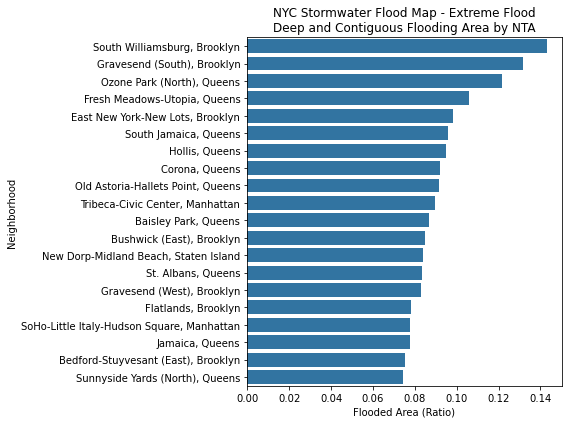

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))

data = (
    nta_merged
    .loc[nta_merged['flood_classification'].isin(['Deep and Contiguous Flooding'])]
    .reset_index(drop=True)
    .sort_values(by='flood_area_ratio' ,ascending=False)
    .head(20)
)

sns.barplot(
    data=data, 
    y='ntaname_boro', 
    x='flood_area_ratio', 
    color='C0',
    ax=ax
)

plt.title('NYC Stormwater Flood Map - Extreme Flood\n\
Deep and Contiguous Flooding Area by NTA', fontsize=12)
plt.xlabel('Flooded Area (Ratio)')
plt.ylabel('Neighborhood')
plt.tight_layout()

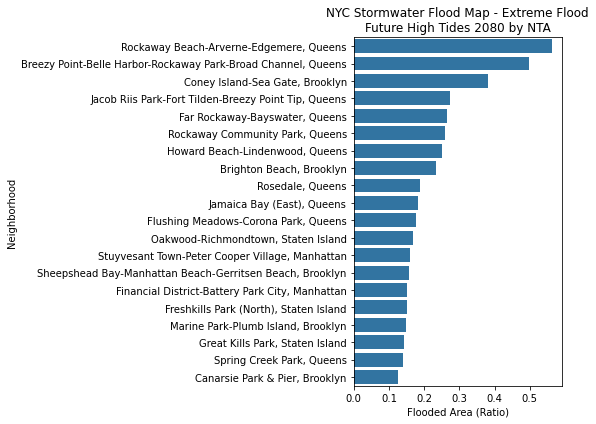

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))

data = (
    nta_merged
    .loc[nta_merged['flood_classification'].isin(['Future High Tides 2080'])]
    .reset_index(drop=True)
    .sort_values(by='flood_area_ratio' ,ascending=False)
    .head(20)
)

sns.barplot(
    data=data, 
    y='ntaname_boro', 
    x='flood_area_ratio', 
    color='C0',
    ax=ax
)

plt.title('NYC Stormwater Flood Map - Extreme Flood\n\
Future High Tides 2080 by NTA', fontsize=12)
plt.xlabel('Flooded Area (Ratio)')
plt.ylabel('Neighborhood')
plt.tight_layout()